In [2]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from keras import callbacks as cb
import os, json, math, librosa
import IPython.display as ipd
import librosa.display as dis
import librosa
import tensorflow as tf
import tensorflow.keras as keras
import matplotlib.pyplot as plt
import numpy as np

from tensorflow.keras import Sequential
from tensorflow.keras.layers import Conv2D, BatchNormalization, Dropout, Flatten, MaxPooling2D, Input, Activation

import sklearn.model_selection as sk
from sklearn.model_selection import train_test_split


2024-03-28 14:42:35.650846: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 14:42:35.717810: I external/local_tsl/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2024-03-28 14:42:35.970044: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-03-28 14:42:37.108619: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


genres/classical/classical.00004.wav


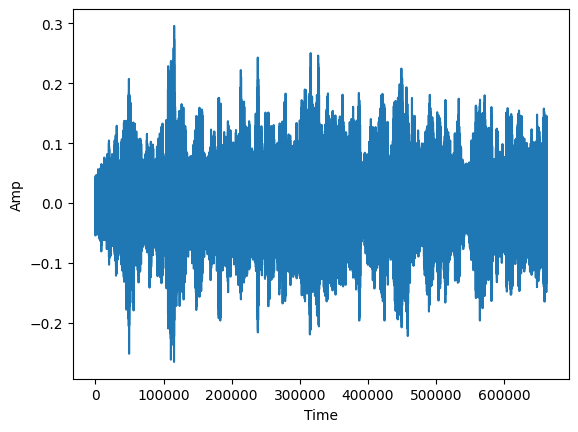

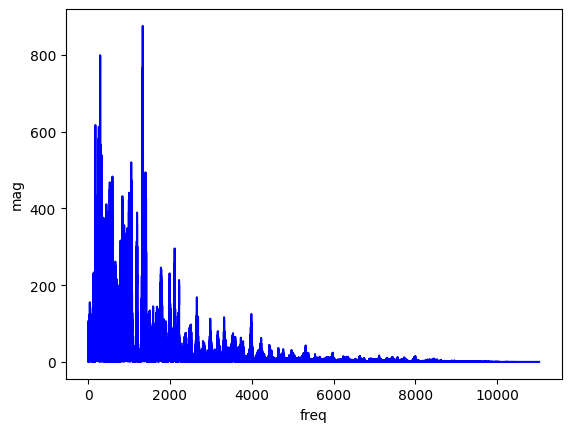

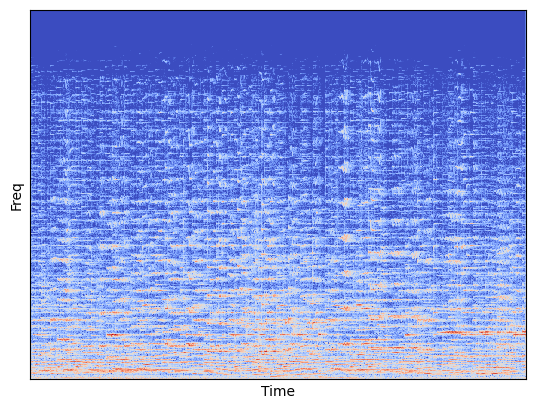

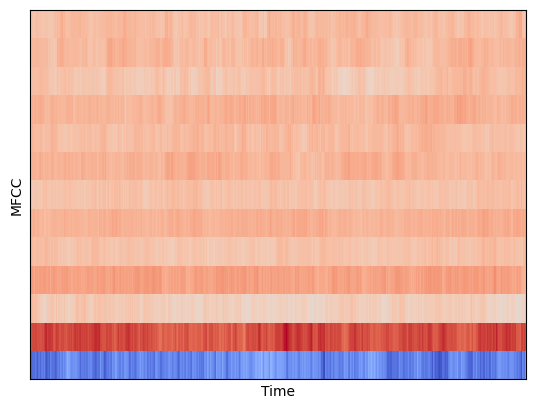

In [3]:
file = "genres/classical/classical.00004.wav"
print(file)


# waveform
signal, sr = librosa.load(file, sr=22050)
plt.plot(signal)
plt.xlabel("Time")
plt.ylabel("Amp")
plt.show()


# fft -> spectrum
fft = np.fft.fft(signal)

magnitude = np.abs(fft)
frequency = np.linspace(0, sr, len(magnitude))
left_freq = frequency[: int(len(frequency) / 2)]
left_mag = magnitude[: int(len(magnitude) / 2)]

plt.plot(left_freq, left_mag, color="b")
plt.xlabel("freq")
plt.ylabel("mag")
plt.show()


# fft
n_fft = 2048  # window when considering performing a single fft
hop_length = 512  # amount shifting after each transform

stft = librosa.core.stft(signal, hop_length=hop_length, n_fft=n_fft)
spectrogram = np.abs(stft)

log_spectrogram = librosa.amplitude_to_db(spectrogram)

librosa.display.specshow(log_spectrogram, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("Freq")
plt.show()


# mfcc
MFCCs = librosa.feature.mfcc(y=signal, n_fft=n_fft, hop_length=hop_length, n_mfcc=13)
librosa.display.specshow(MFCCs, sr=sr, hop_length=hop_length)
plt.xlabel("Time")
plt.ylabel("MFCC")
plt.show()


In [4]:
# Getting Genres from folder name

MUSIC = 'genres'
music_dataset = [] # File locations for each wav file 
genre_target = [] # 
for root, dirs, files in os.walk(MUSIC):
    for name in files:
        filename = os.path.join(root, name)
        if filename != 'genres/jazz/jazz.00054.wav':
            music_dataset.append(filename)
            genre_target.append(filename.split("/"))
            

In [5]:
# print("genres in dataset: ", set(genre_target))

In [6]:
audio_path = music_dataset[500]

x , sr = librosa.load(audio_path)
librosa.load(audio_path, sr=None)

ipd.Audio(audio_path)



In [7]:
# Visualizing Audio File as a waveform
plt.figure(figsize=(16, 5))
# librosa.display.waveplot(x, sr=sr)

<Figure size 1600x500 with 0 Axes>

<Figure size 1600x500 with 0 Axes>

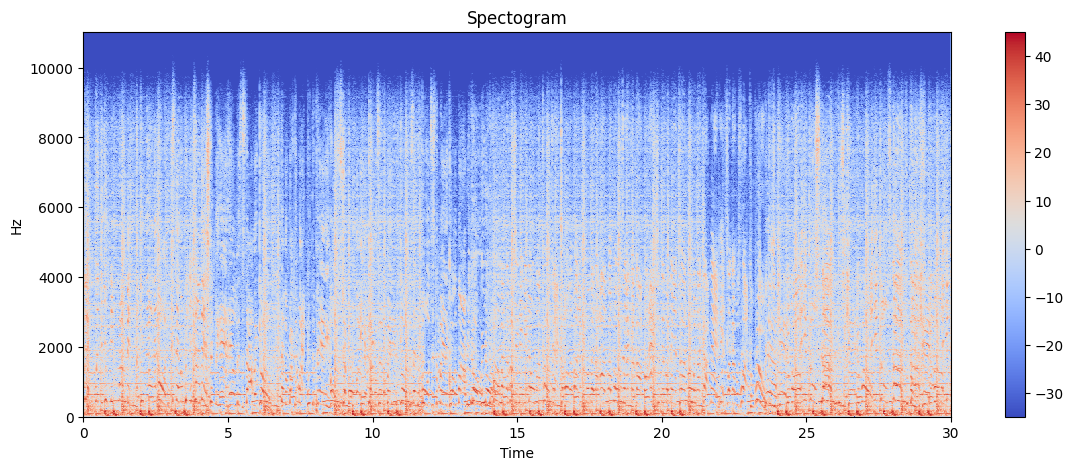

In [8]:
# Visualizing audio file as a spectogram
X = librosa.stft(x)
Xdb = librosa.amplitude_to_db(abs(X))
plt.figure(figsize=(14, 5))
librosa.display.specshow(Xdb, sr=sr, x_axis='time', y_axis='hz')
plt.title('Spectogram')
plt.colorbar()

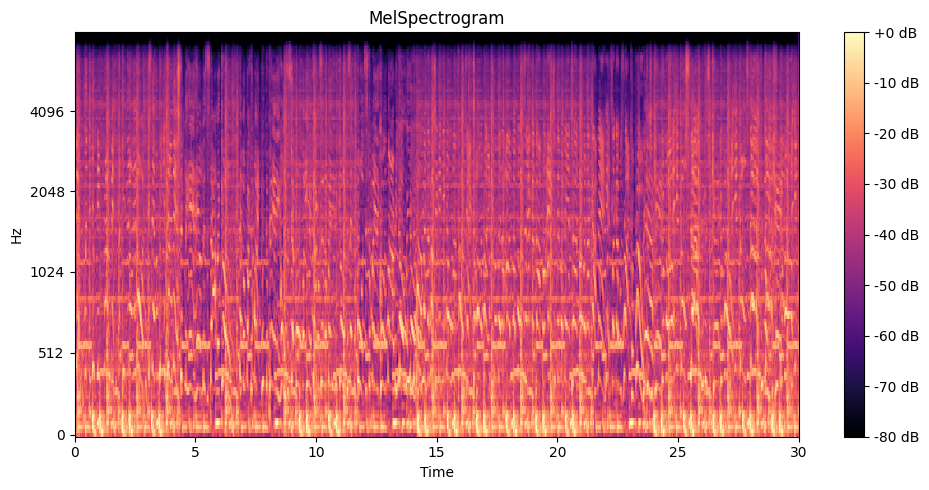

In [9]:
file_location = audio_path
y, sr = librosa.load(file_location)
melSpec = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=128)
melSpec_dB = librosa.power_to_db(melSpec, ref=np.max)
plt.figure(figsize=(10, 5))
librosa.display.specshow(melSpec_dB, x_axis='time', y_axis='mel', sr=sr, fmax=8000)
plt.colorbar(format='%+1.0f dB')
plt.title("MelSpectrogram")
plt.tight_layout()
plt.show()


Extracting MFCCs from music dataset and saves them into a json file along witgh genre labels.<br>
        :param dataset_path (str): Path to dataset<br>
        :param json_path (str): Path to json file used to save MFCCs<br>
        :param num_mfcc (int): Number of coefficients to extract<br>
        :param n_fft (int): Interval we consider to apply FFT. Measured in # of samples<br>
        :param hop_length (int): Sliding window for FFT. Measured in # of samples<br>
        :param: num_segments (int): Number of segments we want to divide sample tracks into


In [10]:
DATASET_PATH = 'genres'
JSON_PATH = "data_10.json"
SAMPLE_RATE = 22050
TRACK_DURATION = 30
SAMPLES_PER_TRACK = SAMPLE_RATE * TRACK_DURATION


def save_mfcc(dataset_path, json_path, num_mfcc=13, n_fft=2048, hop_length=512, num_segments=5):
    data = {
        "mapping": [],
        "labels": [],
        "mfcc": []
    }

    samples_per_segment = int(SAMPLES_PER_TRACK / num_segments)
    num_mfcc_vectors_per_segment = math.ceil(samples_per_segment / hop_length)
    for i, (dirpath, dirnames, filenames) in enumerate(os.walk(dataset_path)):
        if dirpath is not dataset_path:
            semantic_label = dirpath.split("/")[-1]
            data["mapping"].append(semantic_label)
            print("\nProcessing: {}".format(semantic_label))
            for f in filenames:
                file_path = os.path.join(dirpath, f)
                if file_path != 'genres/jazz/jazz.00054.wav':
                    signal, sample_rate = librosa.load(file_path, sr=SAMPLE_RATE)
                    for d in range(num_segments):
                        start = samples_per_segment * d
                        finish = start + samples_per_segment
                        mfcc = librosa.feature.mfcc(y=signal[start:finish], sr=sample_rate, n_mfcc=num_mfcc, n_fft=n_fft, hop_length=hop_length)
                        mfcc = mfcc.T
                        if len(mfcc) == num_mfcc_vectors_per_segment:
                            data["mfcc"].append(mfcc.tolist())
                            data["labels"].append(i-1)
    with open(json_path, "w") as fp:
        json.dump(data, fp, indent=4)
save_mfcc(DATASET_PATH, JSON_PATH, num_segments=15)
print("process finished")


Processing: country

Processing: reggae

Processing: disco

Processing: rock

Processing: hiphop

Processing: jazz

Processing: classical

Processing: pop

Processing: metal

Processing: blues
process finished


In [18]:
DATA_PATH = "./data_10.json"

def load_data(data_path):

    with open(data_path, "r") as fp:
        data = json.load(fp)

    X = np.array(data["mfcc"])
    y = np.array(data["labels"])
    z = np.array(data['mapping'])
    return X, y, z


def plot_history(history):
    fig, axs = plt.subplots(2)
    axs[0].plot(history.history["accuracy"], label="train accuracy")
    axs[0].plot(history.history["val_accuracy"], label="test accuracy")
    axs[0].set_ylabel("Accuracy")
    axs[0].legend(loc="lower right")
    axs[0].set_title("Accuracy eval")
    
    axs[1].plot(history.history["loss"], label="train error")
    axs[1].plot(history.history["val_loss"], label="test error")
    axs[1].set_ylabel("Error")
    axs[1].set_xlabel("Epoch")
    axs[1].legend(loc="upper right")
    axs[1].set_title("Error eval")

    plt.show()

X, y, z = load_data(DATA_PATH)
def prepare_datasets(test_size, validation_size):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, shuffle = True,random_state =42)
    X_train, X_validation, y_train, y_validation = train_test_split(X_train, y_train, test_size=1, shuffle = True, random_state = 42)

    # add an axis to input sets
    X_train = X_train[..., np.newaxis]
    X_validation = X_validation[..., np.newaxis]
    X_test = X_test[..., np.newaxis]

    return X_train, X_validation, X_test, y_train, y_validation, y_test, z


def build_model(input_shape):
    model = Sequential()
#     1st conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', input_shape=input_shape, kernel_initializer = 'he_normal'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 2nd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.MaxPooling2D((3, 3), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # 3rd conv layer
    model.add(keras.layers.Conv2D(32, (2, 2), activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.MaxPooling2D((2, 2), strides=(2, 2), padding='same'))
    model.add(keras.layers.BatchNormalization())

    # flatten output and feed it into dense layer
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(128, activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dropout(0.5))
    model.add(keras.layers.Dense(64, activation='relu', kernel_initializer = 'he_normal'))
    model.add(keras.layers.Dropout(0.5))
    # output layer
    model.add(keras.layers.Dense(10, activation='softmax'))
    return model


def predict(model, X, y):
    prediction = model.predict(X)
    predicted_index = np.argmax(prediction, axis=1)
    target = z[y]
    predicted = z[predicted_index]

    # Print both predicted class and its probability
    for i in range(len(predicted)):
        print("Sample {}: Target: {}, Predicted label: {} (Probability: {:.2f})".format(i+1, target[i], predicted[i], prediction[i][predicted_index[i]]))



In [13]:
# os.mkdir('callbacks')

/var/data/python/lib/python3.11/site-packages/keras/src/layers/convolutional/base_conv.py:99: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 86, 12, 32)     │           160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 43, 6, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 43, 6, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 42, 5, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 21, 3, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 21, 3, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 20, 2, 32)      │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 10, 1, 32)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 10, 1, 32)      │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 320)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        41,088 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 10)             │           650 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 58,794 (229.66 KB)

 Trainable params: 58,602 (228.91 KB)

 Non-trainable params: 192 (768.00 B)

Epoch 1/200
27/27 - 8s - 290ms/step - accuracy: 0.2297 - loss: 2.4746 - val_accuracy: 0.1943 - val_loss: 3.5047
Epoch 2/200
27/27 - 5s - 183ms/step - accuracy: 0.3513 - loss: 1.7888 - val_accuracy: 0.1682 - val_loss: 3.3710
Epoch 3/200
27/27 - 5s - 182ms/step - accuracy: 0.4043 - loss: 1.6180 - val_accuracy: 0.1789 - val_loss: 2.8129
Epoch 4/200
27/27 - 5s - 179ms/step - accuracy: 0.4467 - loss: 1.5100 - val_accuracy: 0.2650 - val_loss: 2.1986
Epoch 5/200
27/27 - 5s - 174ms/step - accuracy: 0.4749 - loss: 1.4296 - val_accuracy: 0.3004 - val_loss: 1.8648
Epoch 6/200
27/27 - 4s - 166ms/step - accuracy: 0.4970 - loss: 1.3506 - val_accuracy: 0.3685 - val_loss: 1.6780
Epoch 7/200
27/27 - 4s - 156ms/step - accuracy: 0.5279 - loss: 1.3062 - val_accuracy: 0.4246 - val_loss: 1.5102
Epoch 8/200
27/27 - 4s - 156ms/step - accuracy: 0.5495 - loss: 1.2502 - val_accuracy: 0.4519 - val_loss: 1.4934
Epoch 9/200
27/27 - 4s - 164ms/step - accuracy: 0.5658 - loss: 1.2074 - val_accuracy: 0.5567 - val_loss:

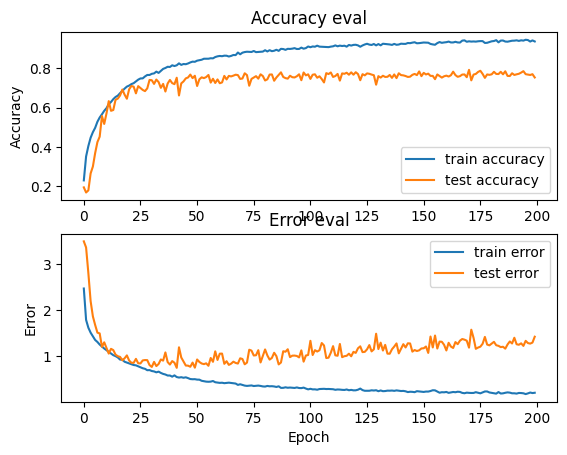

47/47 - 0s - 3ms/step - accuracy: 0.7530 - loss: 1.4246

Test accuracy: 0.7530040144920349


In [14]:
# get train, validation, test splits
X_train, X_validation, X_test, y_train, y_validation, y_test, z = prepare_datasets(0.1, 0)

# create network
input_shape = (X_train.shape[1], X_train.shape[2], 1)
model = build_model(input_shape)

# compile model
optimiser = keras.optimizers.Adam(learning_rate=0.0025)
model.compile(optimizer=optimiser,loss='sparse_categorical_crossentropy', metrics=['accuracy'])
my_callbacks = [tf.keras.callbacks.ModelCheckpoint(
    filepath = "/kaggle/working/callbacks.keras",
    monitor = "val_loss",
    mode = "min"
)]
model.summary()
history = model.fit(X_train, y_train, validation_data=(X_test, y_test), batch_size=512, epochs=200, verbose = 2, callbacks = my_callbacks)
# plot accuracy/error for training and validation
plot_history(history)

# evaluate model on test set
test_loss, test_acc = model.evaluate(X_test, y_test, verbose=2)
print('\nTest accuracy:', test_acc)

In [19]:
# pick a sample to predict from the test set
X_to_predict = X_test
y_to_predict = y_test
# predict sample
print(predict(model, X_to_predict, y_to_predict))

47/47 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step
Sample 1: Target: pop, Predicted label: pop (Probability: 1.00)
Sample 2: Target: classical, Predicted label: classical (Probability: 1.00)
Sample 3: Target: classical, Predicted label: classical (Probability: 1.00)
Sample 4: Target: rock, Predicted label: rock (Probability: 0.69)
Sample 5: Target: hiphop, Predicted label: hiphop (Probability: 1.00)
Sample 6: Target: hiphop, Predicted label: hiphop (Probability: 1.00)
Sample 7: Target: classical, Predicted label: classical (Probability: 1.00)
Sample 8: Target: disco, Predicted label: disco (Probability: 0.53)
Sample 9: Target: pop, Predicted label: pop (Probability: 0.99)
Sample 10: Target: country, Predicted label: country (Probability: 1.00)
Sample 11: Target: metal, Predicted label: metal (Probability: 1.00)
Sample 12: Target: country, Predicted label: country (Probability: 0.99)
Sample 13: Target: metal, Predicted label: metal (Probability: 1.00)
Sample 14: Target: disco, Predicted label: hiph

In [ ]:
model.evaluate(X_test, y_test)

47/47 [==============================] - 0s 3ms/step - loss: 1.2944 - accuracy: 0.7724


[1.294411540031433, 0.7723631262779236]